In [59]:
import sys
import os

project_root = os.path.abspath("..")  # Adjust if needed
sys.path.append(project_root)

In [103]:
from scipy.stats import f_oneway
from scipy import stats
import pandas as pd
from newsies.articles import Archive
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
import nltk
import spacy
from tqdm import tqdm  # For progress tracking
from sklearn.decomposition import PCA


In [61]:
arch = Archive()
arch.archive_path="/home/mpeters/Projects/newsies/daily_news/apnews.com"
arch.refresh()
arch.build_knn()
arch.load_cluster_profiles()


In [62]:
arch.cluster_profile

,item_id,cluster,dim000,dim001,dim002,dim003,dim004,dim005,dim006,dim007,...,dim758,dim759,dim760,dim761,dim762,dim763,dim764,dim765,dim766,dim767
0,7e1df8310d6e139010ab7f4e4069c199,0,-0.006101,0.076638,0.019755,-0.034498,0.028335,0.045292,-0.032759,-0.018148,...,-0.037530,0.028053,-0.090672,0.011918,0.022750,0.003011,-0.001596,0.033189,0.019275,0.016166
1,e3dfd040f10e047d7cc95cbb8a295b28,13,0.031605,0.046112,0.029032,0.025714,-0.015637,0.053910,0.081190,0.013265,...,-0.019022,0.004716,-0.027974,-0.000832,0.018185,0.010391,-0.027068,0.024229,0.009575,0.035396
2,fe1eacbdaebc6564f2c3559b999e6c0f,13,0.001723,0.019956,0.038399,-0.000051,-0.047724,-0.009798,0.086049,-0.023688,...,-0.005411,-0.002877,-0.001626,-0.008125,0.035817,-0.026167,-0.004246,0.019686,0.030784,0.041713
3,78f544fb2c8b593c88a0c1f0e0ad9c5f,2,-0.011511,0.091708,0.015462,0.012447,-0.006586,0.013928,0.093391,-0.004966,...,-0.006031,0.014875,-0.021892,-0.006279,-0.013899,-0.048686,-0.009122,0.027826,0.018659,0.043423
4,cd50406e3f4e26418e231c26cb70b2c2,3,0.030498,0.009215,0.000218,-0.010657,-0.013035,-0.039478,0.003263,-0.019784,...,0.009830,0.032671,0.027984,0.014614,0.018216,-0.025780,-0.015505,0.023792,0.017729,-0.022188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,cc38040eafe556d3d90771509a150449,18,0.040624,0.057384,0.001765,0.014202,-0.003752,0.000817,-0.000175,-0.001549,...,0.034255,0.014549,-0.088317,-0.051838,-0.019511,-0.000161,-0.031357,-0.003449,0.013458,0.027748
518,dd0809cd5b542dcb9888a20607694350,23,0.047182,0.083468,0.020272,-0.020723,0.053965,0.010693,-0.004071,0.007126,...,0.015952,0.011248,-0.001503,0.053186,-0.004158,0.063970,0.000866,-0.005376,-0.006952,0.024609
519,af9d922957d2980c141b06e2abd59ba7,15,0.027440,0.032471,0.019852,0.016482,-0.029449,-0.004137,0.100802,-0.013462,...,-0.017569,0.011494,-0.063199,-0.002261,0.002667,-0.014129,-0.034700,0.004643,-0.009031,0.034832
520,b2029d8296fe1da8d402376ef1eefb9f,7,0.020093,0.078926,0.005774,-0.006228,-0.021008,-0.023682,-0.007124,-0.047041,...,-0.028713,-0.017456,-0.071539,-0.030583,0.007887,0.020062,-0.024752,0.020255,-0.029219,-0.017048


In [63]:
from sentence_transformers import SentenceTransformer
embedding_model: SentenceTransformer = None


def _init_():
    global embedding_model
    device_str = "cuda" if torch.cuda.is_available() else "cpu"
    if embedding_model is None:
        embedding_model = SentenceTransformer(
            "all-mpnet-base-v2", device=device_str
        )  # Fast and good quality

_init_()

In [81]:
knowledge_space = pd.read_csv("knowledge_space_embeddings.csv")
knowledge_base = knowledge_space.drop("Unnamed: 0", axis=1)
knowledge_base.columns

Index(['word', 'dim000', 'dim001', 'dim002', 'dim003', 'dim004', 'dim005',
       'dim006', 'dim007', 'dim008',
       ...
       'dim758', 'dim759', 'dim760', 'dim761', 'dim762', 'dim763', 'dim764',
       'dim765', 'dim766', 'dim767'],
      dtype='object', length=769)

```python
import nltk
import spacy
import pandas as pd
from sentence_transformers import SentenceTransformer
from tqdm import tqdm  # For progress tracking

# Load NLTK words
nltk.download("words")
from nltk.corpus import words

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Define batch size
BATCH_SIZE = 5000  # Process words in smaller chunks

# Function to extract named entities from batches
def get_spacy_entities(word_list):
    entities = set()
    for i in tqdm(range(0, len(word_list), BATCH_SIZE), desc="Processing NER in batches"):
        batch_text = " ".join(word_list[i:i+BATCH_SIZE])  # Process a batch at a time
        doc = nlp(batch_text)
        entities.update([ent.text.lower() for ent in doc.ents])
    return entities

# Get vocab words from NLTK
nltk_vocab = set(words.words())

# Extract named entities from the vocabulary
spacy_entities = get_spacy_entities(list(nltk_vocab))

# Merge vocab and filter out short words
full_vocab = list(nltk_vocab.union(spacy_entities))
full_vocab = [word for word in full_vocab if len(word) > 2]  # Remove very short words

# Load embedding model
embedding_model = SentenceTransformer("all-mpnet-base-v2")

# Generate embeddings for the vocabulary
vocab_embeddings = embedding_model.encode(full_vocab, convert_to_numpy=True)

# Store in DataFrame
knowledge_space = pd.DataFrame(
    [{"word":word, **{f"dim{i:03}":e for i,e in enumerate(embeddings)}} for word,embeddings in zip(full_vocab,vocab_embeddings)],
    index=full_vocab)

# Save for later use
knowledge_space.to_csv("knowledge_space_embeddings.csv")

print("Knowledge space built with", len(full_vocab), "words.")
```


In [68]:
cluster_profiles = arch.cluster_profile

In [83]:
# Function to find closest word based on cosine similarity
def closest_word(article_embedding, knowledge_space_embeddings, knowledge_words):
    similarities = cosine_similarity(article_embedding.reshape(1, -1), knowledge_space_embeddings)
    return knowledge_words[np.argmax(similarities)]  # Select the corresponding word

# Extract only the numeric embedding columns (dim000 to dim767)
embedding_columns = [f'dim{str(i).zfill(3)}' for i in range(0, 768)]  # Ensure correct range

# Ensure knowledge_space has the correct numeric data
knowledge_space_embeddings = knowledge_space[embedding_columns].astype(np.float32).values  
knowledge_words = knowledge_space['word'].values  # Extract words separately

# Ensure cluster_profiles only selects correct embedding columns
cluster_profiles['word'] = cluster_profiles[embedding_columns].apply(
    lambda row: closest_word(row.values.astype(np.float32), knowledge_space_embeddings, knowledge_words), axis=1
)


In [84]:
cluster_profiles.columns

Index(['item_id', 'cluster', 'dim000', 'dim001', 'dim002', 'dim003', 'dim004',
       'dim005', 'dim006', 'dim007',
       ...
       'dim759', 'dim760', 'dim761', 'dim762', 'dim763', 'dim764', 'dim765',
       'dim766', 'dim767', 'word'],
      dtype='object', length=771)

In [86]:
# Function to compute cluster stats
def compute_cluster_stats(df):
    cluster_stats = []
    # Select only the numeric columns (embeddings) for aggregation
    embedding_columns = df.columns[2:-1]  # assuming first two columns are 'item_id' and 'cluster' and last column is "word"
    
    for cluster_id, group in df.groupby('cluster'):
        # Loop over aggregation types: min, mean, max
        for agg_enum, agg in enumerate(["min", "mean", "max"]):
            # Apply aggregation for each type (min, mean, max) to each dimension (dim000 to dim767)
            agg_values = group[embedding_columns].agg(agg).values
            
            # Create a DataFrame with the aggregation results
            agg_df = pd.DataFrame([agg_values], columns=embedding_columns)
            agg_df['cluster'] = cluster_id
            agg_df['aggregate'] = agg_enum  # 0 = min, 1 = mean, 2 = max
            
            # Append this to the list of cluster stats
            cluster_stats.append(agg_df)
    
    # Concatenate the stats into a single DataFrame
    return pd.concat(cluster_stats)

# Generate the clusters dataframe
clusters = compute_cluster_stats(cluster_profiles)

# The 'clusters' dataframe now contains rows for min, mean, and max per cluster, each with columns dim001 to dim767


In [87]:
clusters

,dim000,dim001,dim002,dim003,dim004,dim005,dim006,dim007,dim008,dim009,...,dim760,dim761,dim762,dim763,dim764,dim765,dim766,dim767,cluster,aggregate
0,-0.045618,-0.024229,-0.039589,-0.077669,-0.091947,-0.037642,-0.084214,-0.056095,-0.061765,-0.069644,...,-0.095957,-0.058169,-0.044502,-0.065788,-0.036700,-0.047974,-0.065507,-0.063153,0,0
0,0.003679,0.027880,-0.001116,-0.009899,-0.009405,0.007417,-0.008591,0.004064,0.010196,-0.004976,...,-0.027851,-0.003271,0.006353,-0.001484,-0.005178,0.017555,0.000862,0.000636,0,1
0,0.056874,0.122224,0.034968,0.058908,0.064382,0.062506,0.053656,0.066239,0.122677,0.064359,...,0.064069,0.061223,0.039105,0.078845,0.028866,0.065849,0.082520,0.045931,0,2
0,-0.017039,0.036887,0.016529,-0.067151,0.018132,0.032482,-0.005614,-0.012014,0.030575,-0.022358,...,-0.073272,-0.009002,0.021001,0.013242,-0.008225,0.046547,0.012390,0.029761,1,0
0,-0.017039,0.036887,0.016529,-0.067151,0.018132,0.032482,-0.005614,-0.012014,0.030575,-0.022358,...,-0.073272,-0.009002,0.021001,0.013242,-0.008225,0.046547,0.012390,0.029761,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.010819,0.130490,0.036113,-0.026702,0.000368,0.016001,-0.008735,-0.022348,-0.007011,0.009691,...,-0.083711,-0.000139,-0.026570,0.039059,-0.004093,-0.013830,-0.007024,0.001843,29,1
0,0.010819,0.130490,0.036113,-0.026702,0.000368,0.016001,-0.008735,-0.022348,-0.007011,0.009691,...,-0.083711,-0.000139,-0.026570,0.039059,-0.004093,-0.013830,-0.007024,0.001843,29,2
0,0.058503,0.113403,0.024631,-0.008536,0.034797,-0.003815,0.027852,0.014457,-0.037101,-0.003546,...,-0.012382,0.029454,-0.006232,0.072393,-0.024512,-0.007859,-0.013331,0.002413,30,0
0,0.058503,0.113403,0.024631,-0.008536,0.034797,-0.003815,0.027852,0.014457,-0.037101,-0.003546,...,-0.012382,0.029454,-0.006232,0.072393,-0.024512,-0.007859,-0.013331,0.002413,30,1


In [88]:
# Ensure cluster_profiles only selects correct embedding columns
clusters['word'] = clusters[embedding_columns].apply(
    lambda row: closest_word(row.values.astype(np.float32), knowledge_space_embeddings, knowledge_words), axis=1
)

In [89]:
clusters.columns

Index(['dim000', 'dim001', 'dim002', 'dim003', 'dim004', 'dim005', 'dim006',
       'dim007', 'dim008', 'dim009',
       ...
       'dim761', 'dim762', 'dim763', 'dim764', 'dim765', 'dim766', 'dim767',
       'cluster', 'aggregate', 'word'],
      dtype='object', length=771)

In [98]:
knowledge_space = knowledge_space.sort_values(by=embedding_columns)
knowledge_space = knowledge_space.drop("Unnamed: 0",axis=1)
knowledge_space

,word,dim000,dim001,dim002,dim003,dim004,dim005,dim006,dim007,dim008,...,dim758,dim759,dim760,dim761,dim762,dim763,dim764,dim765,dim766,dim767
1489,unmesh,-0.146501,0.008197,-0.007693,-0.030331,-0.007747,0.006659,0.005950,0.005655,0.041230,...,-0.012806,0.009304,-0.028790,-0.023348,-0.009284,-0.056569,-0.036914,-0.029512,0.003426,-0.046486
76406,unneth,-0.124130,0.050308,-0.004130,-0.044552,-0.024810,0.007145,0.000901,-0.022600,0.029744,...,0.017455,0.032284,-0.038199,-0.022229,0.007282,-0.021525,-0.056481,-0.042918,0.017381,-0.024289
3697,unhot,-0.119720,-0.033913,0.005608,-0.010746,-0.005240,0.055929,0.000635,-0.009495,0.024269,...,0.031296,0.051248,-0.024362,-0.045225,-0.008016,-0.014348,-0.039685,0.026688,-0.013064,0.014054
241927,unscreen,-0.119301,-0.085488,-0.011166,-0.015668,0.030990,0.029362,0.013716,0.066176,0.031593,...,0.002736,0.015353,-0.041049,-0.032845,0.015559,0.002442,-0.028902,0.032146,-0.042284,-0.000767
180795,awhet,-0.114782,0.028921,-0.031454,0.031143,-0.052813,0.000260,-0.009082,-0.014635,-0.004588,...,0.033395,0.023626,0.070596,-0.009080,0.023559,0.001506,-0.022406,0.033315,-0.024022,-0.055834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236940,Razoumofskya,0.110370,0.009259,0.011952,0.015751,0.017051,0.009281,-0.031752,0.006973,-0.014375,...,-0.036596,-0.009727,-0.012087,-0.031643,0.034465,0.026690,-0.014052,0.011815,-0.008111,0.008510
7856,trionychoideachid,0.112092,-0.012859,0.017829,-0.013720,-0.012004,0.032545,0.035639,0.004057,-0.001015,...,-0.047196,0.019539,-0.019754,0.010495,-0.020317,0.057439,-0.040918,0.025925,-0.002017,-0.010904
216583,Trionychoideachid,0.112092,-0.012859,0.017829,-0.013720,-0.012004,0.032545,0.035639,0.004057,-0.001015,...,-0.047196,0.019539,-0.019754,0.010495,-0.020317,0.057439,-0.040918,0.025925,-0.002017,-0.010904
253123,wajang jessur nucleoloid,0.112295,0.077483,0.015239,-0.005851,-0.010957,0.027649,0.000676,0.033419,0.054308,...,-0.008774,-0.009688,-0.002268,0.005101,-0.021747,-0.029317,0.045301,0.074110,-0.055519,-0.036347


In [104]:

# Convert word embeddings to numerical 2D space
pca = PCA(n_components=2)
knowledge_2d = pca.fit_transform(knowledge_space[embedding_columns])  # Reduce embeddings to (word_count, 2)

# Create a mapping from words to their 2D positions
word_to_2d = {word: coord for word, coord in zip(knowledge_space['word'], knowledge_2d)}

In [106]:
def get_word_coords(word):
    return word_to_2d.get(word, np.array([np.nan, np.nan]))  # Handle missing words gracefully

# Convert cluster and article words to coordinates
clusters[['x', 'y']] = clusters['word'].apply(lambda w: pd.Series(get_word_coords(w)))
cluster_profiles[['x', 'y']] = cluster_profiles['word'].apply(lambda w: pd.Series(get_word_coords(w)))


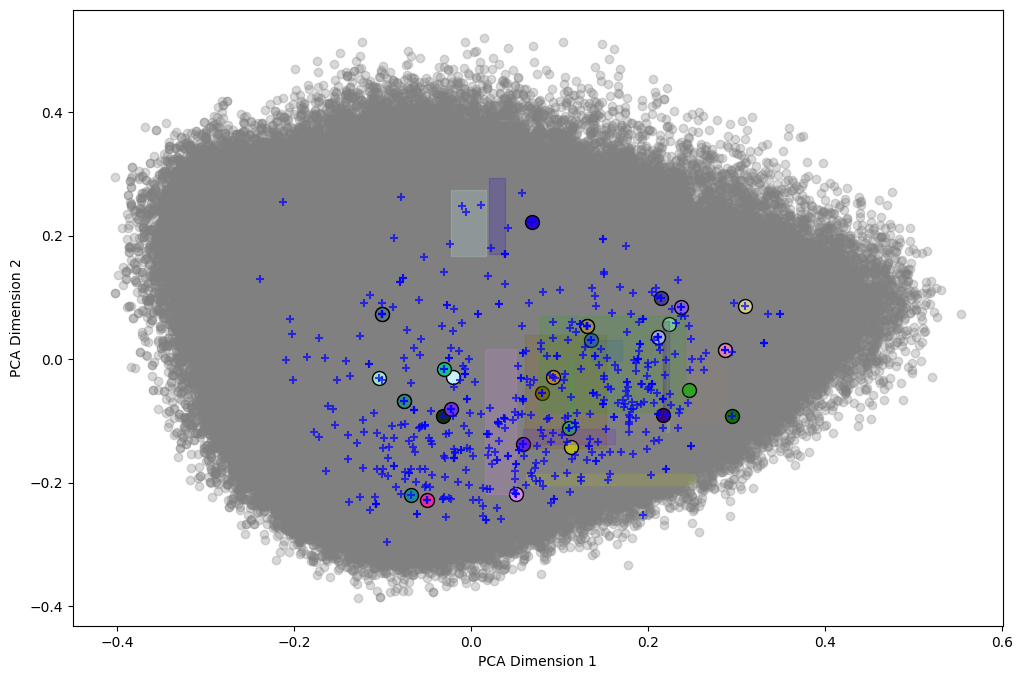

In [110]:
plt.figure(figsize=(12, 8))

# Plot the knowledge space background (light gray dots)
plt.scatter(knowledge_2d[:, 0], knowledge_2d[:, 1], color='gray', alpha=0.3, label="Knowledge Space Words")

# Plot clusters as circles & min-max rectangles
for cluster_id, group in clusters.groupby('cluster'):
    color = np.random.rand(3,)  # Unique color per cluster

    # Extract min, mean, max points
    min_coords = group[group['aggregate'] == 0][['x', 'y']].values[0]
    mean_coords = group[group['aggregate'] == 1][['x', 'y']].values[0]
    max_coords = group[group['aggregate'] == 2][['x', 'y']].values[0]

    # Draw mean point
    plt.scatter(mean_coords[0], mean_coords[1], color=color, edgecolors='black', s=100, label=f"Cluster {cluster_id}")

    # Draw min-max rectangle
    plt.fill_between([min_coords[0], max_coords[0]], min_coords[1], max_coords[1], color=color, alpha=0.2)

# Plot individual articles (small + markers)
plt.scatter(cluster_profiles['x'], cluster_profiles['y'], marker='+', color='blue', alpha=0.7, label="Articles")

plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
#plt.legend()
plt.show()


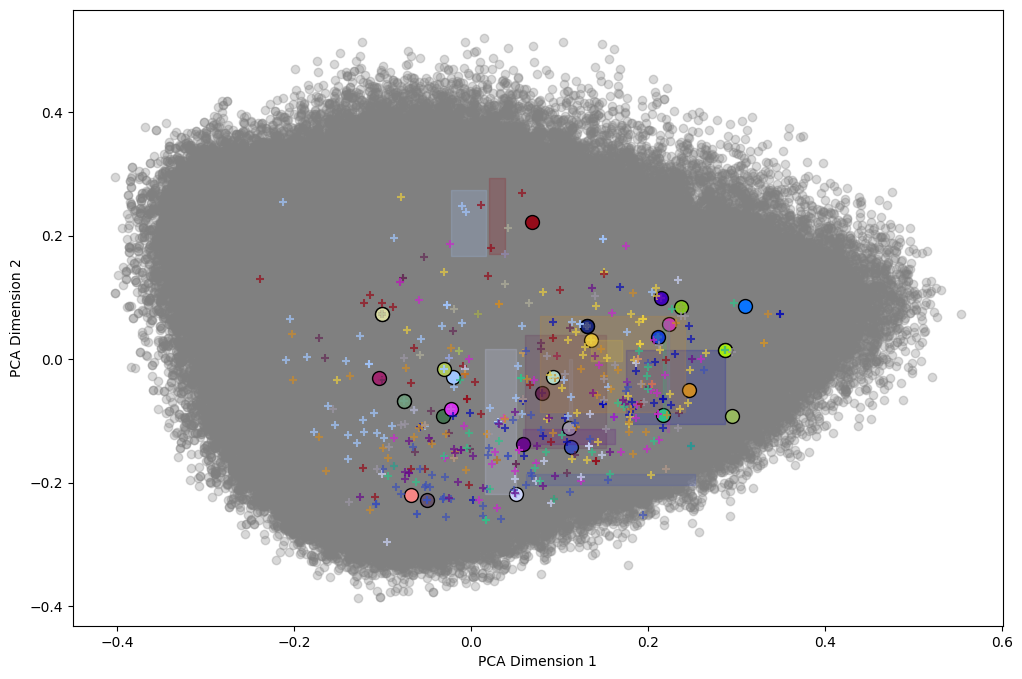

In [109]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Step 1: Reduce embeddings to 2D using PCA
pca = PCA(n_components=2)
knowledge_2d = pca.fit_transform(knowledge_space[embedding_columns])  # Project embeddings to 2D

# Create a mapping from words to their 2D positions
word_to_2d = {word: coord for word, coord in zip(knowledge_space['word'], knowledge_2d)}

# Step 2: Convert cluster and article words to 2D coordinates
def get_word_coords(word):
    return word_to_2d.get(word, np.array([np.nan, np.nan]))  # Handle missing words gracefully

clusters[['x', 'y']] = clusters['word'].apply(lambda w: pd.Series(get_word_coords(w)))
cluster_profiles[['x', 'y']] = cluster_profiles['word'].apply(lambda w: pd.Series(get_word_coords(w)))

# Step 3: Assign colors to clusters
unique_clusters = clusters['cluster'].unique()
cluster_colors = {cluster: np.random.rand(3,) for cluster in unique_clusters}  # Generate distinct colors

# Step 4: Plot Data
plt.figure(figsize=(12, 8))

# Plot the knowledge space background (light gray dots)
plt.scatter(knowledge_2d[:, 0], knowledge_2d[:, 1], color='gray', alpha=0.3, label="Knowledge Space Words")

# Plot clusters and rectangles
for cluster_id, group in clusters.groupby('cluster'):
    color = cluster_colors[cluster_id]  # Get cluster color

    # Extract min, mean, max points
    min_coords = group[group['aggregate'] == 0][['x', 'y']].values[0]
    mean_coords = group[group['aggregate'] == 1][['x', 'y']].values[0]
    max_coords = group[group['aggregate'] == 2][['x', 'y']].values[0]

    # Draw mean point (circle)
    plt.scatter(mean_coords[0], mean_coords[1], color=color, edgecolors='black', s=100, label=f"Cluster {cluster_id}")

    # Draw min-max rectangle (semi-transparent)
    plt.fill_between([min_coords[0], max_coords[0]], min_coords[1], max_coords[1], color=color, alpha=0.2)

# Plot individual articles (+ markers, same color as their cluster)
for cluster_id, group in cluster_profiles.groupby('cluster'):
    color = cluster_colors[cluster_id]
    plt.scatter(group['x'], group['y'], marker='+', color=[color], alpha=0.7, label=f"Articles in Cluster {cluster_id}")

plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
#plt.legend()
plt.show()


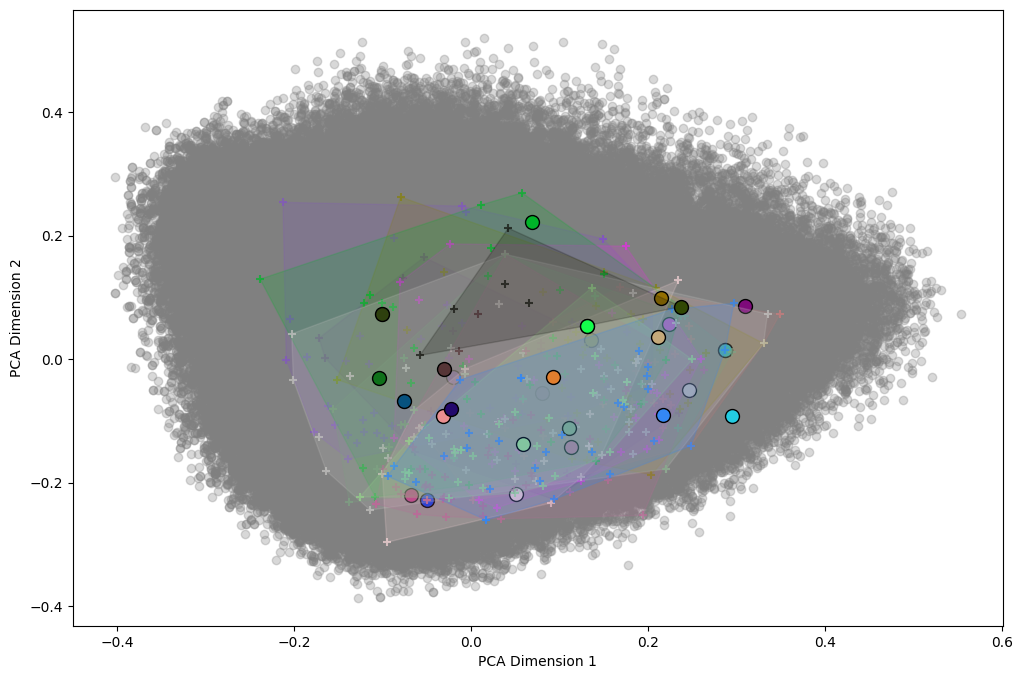

In [111]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull

# Step 1: Project all embeddings to 2D using PCA
pca = PCA(n_components=2)
knowledge_2d = pca.fit_transform(knowledge_space[embedding_columns])

# Mapping words to PCA coordinates
word_to_2d = {word: coord for word, coord in zip(knowledge_space['word'], knowledge_2d)}

# Convert words in cluster_profiles & clusters to PCA coordinates
clusters[['x', 'y']] = clusters['word'].apply(lambda w: pd.Series(word_to_2d.get(w, [np.nan, np.nan])))
cluster_profiles[['x', 'y']] = cluster_profiles['word'].apply(lambda w: pd.Series(word_to_2d.get(w, [np.nan, np.nan])))

# Assign colors per cluster
unique_clusters = clusters['cluster'].unique()
cluster_colors = {cluster: np.random.rand(3,) for cluster in unique_clusters}

plt.figure(figsize=(12, 8))

# Plot knowledge space background
plt.scatter(knowledge_2d[:, 0], knowledge_2d[:, 1], color='gray', alpha=0.3, label="Knowledge Space Words")

for cluster_id, group in cluster_profiles.groupby('cluster'):
    color = cluster_colors[cluster_id]

    # Get PCA coordinates of articles in this cluster
    cluster_points = group[['x', 'y']].dropna().values
    
    if len(cluster_points) > 2:
        # Compute convex hull to form an enclosing shape
        hull = ConvexHull(cluster_points)
        hull_vertices = cluster_points[hull.vertices]
        plt.fill(hull_vertices[:, 0], hull_vertices[:, 1], color=color, alpha=0.2)

    # Plot cluster mean as a large circle
    mean_coords = clusters[(clusters['cluster'] == cluster_id) & (clusters['aggregate'] == 1)][['x', 'y']].values[0]
    plt.scatter(mean_coords[0], mean_coords[1], color=color, edgecolors='black', s=100, label=f"Cluster {cluster_id}")

    # Plot individual articles as small '+' markers
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], marker='+', color=[color], alpha=0.7)

plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
#plt.legend()
plt.show()


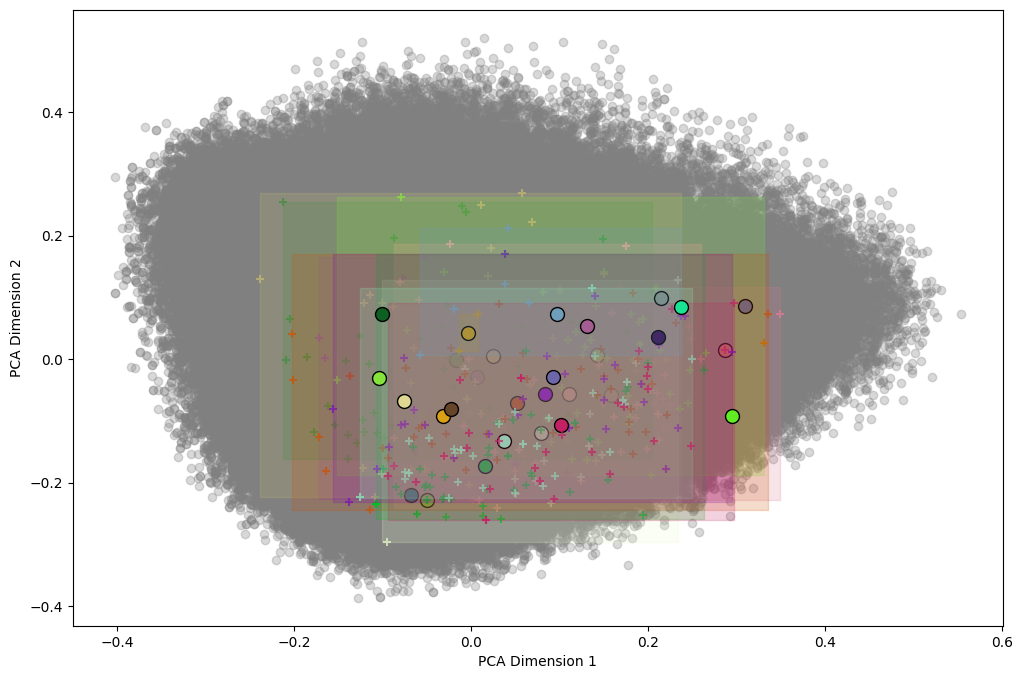

In [113]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Step 1: PCA Projection of Knowledge Space
pca = PCA(n_components=2)
knowledge_2d = pca.fit_transform(knowledge_space[embedding_columns])

# Map words to PCA coordinates
word_to_2d = {word: coord for word, coord in zip(knowledge_space['word'], knowledge_2d)}

# Step 2: Assign PCA coordinates to clusters & cluster_profiles
clusters[['x', 'y']] = clusters['word'].map(word_to_2d).apply(pd.Series)
cluster_profiles[['x', 'y']] = cluster_profiles['word'].map(word_to_2d).apply(pd.Series)

# Step 3: Compute Min/Max/Mean PCA Values Per Cluster
cluster_stats = []
for cluster_id, group in cluster_profiles.groupby('cluster'):
    x_min, y_min = group[['x', 'y']].min()
    x_max, y_max = group[['x', 'y']].max()
    x_mean, y_mean = group[['x', 'y']].mean()
    
    cluster_stats.append((cluster_id, 0, x_min, y_min))  # Min
    cluster_stats.append((cluster_id, 1, x_mean, y_mean))  # Mean
    cluster_stats.append((cluster_id, 2, x_max, y_max))  # Max

cluster_pca_stats = pd.DataFrame(cluster_stats, columns=['cluster', 'aggregate', 'x', 'y'])

# Assign Colors Per Cluster
unique_clusters = clusters['cluster'].unique()
cluster_colors = {cluster: np.random.rand(3,) for cluster in unique_clusters}

plt.figure(figsize=(12, 8))

# Plot Knowledge Space Words in Background
plt.scatter(knowledge_2d[:, 0], knowledge_2d[:, 1], color='gray', alpha=0.3, label="Knowledge Space")

for cluster_id, group in cluster_profiles.groupby('cluster'):
    color = cluster_colors[cluster_id]

    # Get PCA coordinates of articles in this cluster
    cluster_points = group[['x', 'y']].dropna().values

    # Get min/max points for rectangle
    cluster_min = cluster_pca_stats[(cluster_pca_stats['cluster'] == cluster_id) & (cluster_pca_stats['aggregate'] == 0)][['x', 'y']].values[0]
    cluster_max = cluster_pca_stats[(cluster_pca_stats['cluster'] == cluster_id) & (cluster_pca_stats['aggregate'] == 2)][['x', 'y']].values[0]

    # Draw a rectangle from min to max
    plt.fill_between([cluster_min[0], cluster_max[0]], cluster_min[1], cluster_max[1], color=color, alpha=0.2)

    # Plot cluster mean as a large circle
    mean_coords = cluster_pca_stats[(cluster_pca_stats['cluster'] == cluster_id) & (cluster_pca_stats['aggregate'] == 1)][['x', 'y']].values[0]
    plt.scatter(mean_coords[0], mean_coords[1], color=color, edgecolors='black', s=100, label=f"Cluster {cluster_id}")

    # Plot individual articles as small '+' markers
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], marker='+', color=[color], alpha=0.7)

plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
#plt.legend()
plt.show()
